In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Without autograd

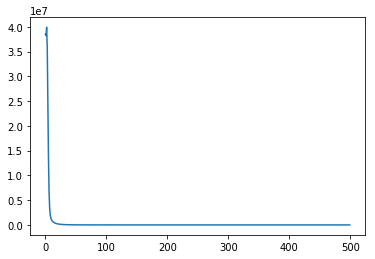

In [8]:
k, N, D_in, H, D_out = 500, 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

w1 = torch.randn(D_in, H)
w2 = torch.randn(H, D_out)

learning_rate = 1e-6
loss_arr = torch.empty(k)

for i in range(k):
    # predict y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # calculate loss
    loss_arr[i] = (y_pred - y).pow(2).sum().item()

    # calculate gradient of w
    grad_y_pred = 2.0*(y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().matmul(grad_h)

    # apply gradient 
    w1 -= learning_rate*grad_w1
    w2 -= learning_rate*grad_w2

plt.plot(loss_arr)
plt.show()

### With autograd

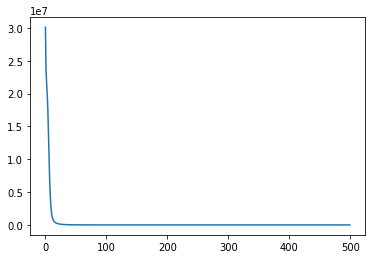

In [9]:
k, N, D_in, H, D_out = 500, 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

w1 = torch.randn(D_in, H, requires_grad=True)
w2 = torch.randn(H, D_out, requires_grad=True)

learning_rate = 1e-6
loss_arr = torch.empty(k)

for i in range(k):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    loss = (y_pred - y).pow(2).sum()
    loss.backward()

    loss_arr[i] = loss.item()

    with torch.no_grad():
        w1 -= learning_rate*w1.grad
        w2 -= learning_rate*w2.grad

        w1.grad.zero_()
        w2.grad.zero_()

plt.plot(loss_arr)
plt.show()

### Using torch.nn
* 위와 동일한 조건임에도 학습률을 더 높여도 오버슈팅이 발생하지 않음
    * 왜?


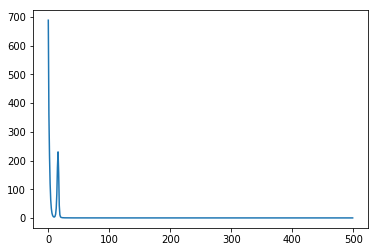

In [10]:
k, N, D_in, H, D_out = 500, 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

learning_rate = 1e-3
loss_arr = torch.empty(k)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out)
)

loss_fn = nn.MSELoss(reduction="sum")

for i in range(k):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    loss_arr[i] = loss.item()

    model.zero_grad()

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

plt.plot(loss_arr)
plt.show()

### Using pytorch optimizer

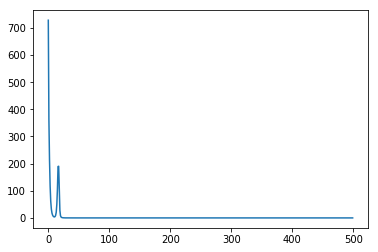

In [11]:
k, N, D_in, H, D_out = 500, 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

learning_rate = 1e-3
loss_arr = torch.empty(k)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out)
)

loss_fn = nn.MSELoss(reduction="sum")

# initalize optimizer
# 가중치의 갱신을 optimizer가 전담함
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(k):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    loss_arr[i] = loss.item()

    # model.zero_grad()
    optimizer.zero_grad()

    loss.backward()

    # with torch.no_grad():
    #     for param in model.parameters():
    #         param -= learning_rate * param.grad
    optimizer.step()

plt.plot(loss_arr)
plt.show()

### User defined nn.Module 

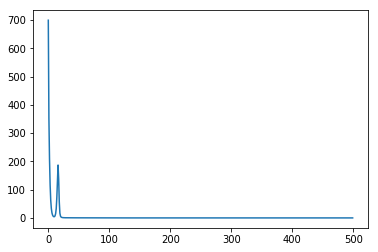

In [13]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

k, N, D_in, H, D_out = 500, 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

learning_rate = 1e-3
loss_arr = torch.empty(k)

model = TwoLayerNet(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(k):
    y_pred = model(x)

    loss = criterion(y_pred, y)
    loss_arr[i] = loss.item()

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
plt.plot(loss_arr)
plt.show()